In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

---------------------

Take mean image as input rather than mean output 

# Retrieving and Preprocess Data

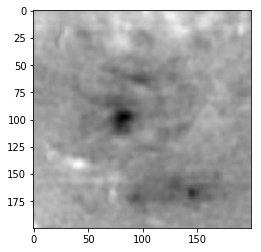

In [2]:
re_list = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
#re_list = np.load('test_npy/7-12-17-preprocessed.npy')
IMG_SIZE = re_list.shape[1]

#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(200, 200, 1) float32


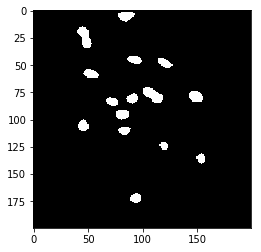

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/Ori_Lin/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (200, 200))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

Shape:(200, 200, 1), Min:0, Max:1, Type:uint8
Number of detected ROIs: 15


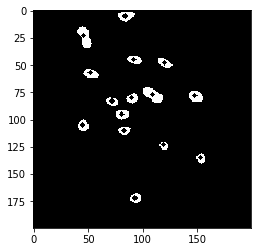

With centroids:
[(93, 172), (153, 135), (119, 123), (83, 110), (45, 105), (81, 95), (72, 83), (90, 80), (148, 78), (109, 77), (52, 57), (120, 48), (92, 45), (46, 23), (84, 5)]


In [4]:
centres, img_with_centroids  = utils.retrieve_centroid(mean_roi, centroid_rad = 2)

plt.imshow(np.squeeze(img_with_centroids), cmap = 'gray')
plt.show()
print('With centroids:')
print(centres)

In [5]:
#calculate mean image

mean_img_ori = utils.mean_image(re_list, IMG_SIZE)
#apply min max norm for mean image
mean_img_ori = utils.min_max_norm(mean_img_ori)
mean_img_ori = np.expand_dims(mean_img_ori, -1)
print('Max value:', np.max(mean_img_ori))
print('Min value:', np.min(mean_img_ori))


Max value: 1.0
Min value: 0.0


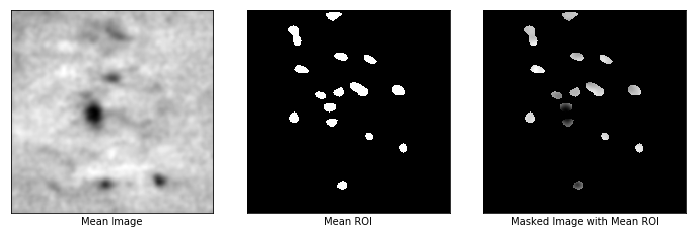

MSE:  0.5853560847720753
Dice coefficient:  0.05754157297837919


In [6]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

captions = ['Mean Image', 'Mean ROI', 'Masked Image with Mean ROI']
plot_comparison([mean_img_ori, mean_roi,masked_img(mean_img_ori, mean_roi)], 
                captions, n_col =3, figsize = (10, 10))
print('MSE: ', MSE_image(np.squeeze(mean_img_ori), mean_roi, IMG_SIZE))
#measure IOU with dice coeff
print('Dice coefficient: ',dice_coef_py(mean_roi, mean_img_ori))

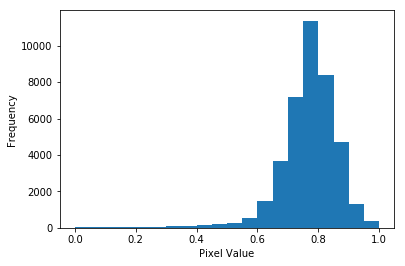

In [7]:
#plot historgram for mean image
plt.hist(mean_img_ori.ravel(),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Model

In [8]:
#hyperparameters 
BATCH_SIZE = 16
MAX_STEP = 5000 #exceeding 5000 steps will crash!
REPEAT = 1000
lr = 1e-3
data_augmentation = False

#Split data: 80% Training, 20% test
y_data = []
for i in range(len(re_list)):
    y_data.append(mean_roi)
    
y_data = np.asarray(y_data)
x_train, x_test, y_train, y_test = train_test_split(re_list, y_data, test_size = 0.2, random_state = 42)

#data generator
if data_augmentation:
    print('Augmented dataset!')
    BATCH_SIZE = 16 #system crash if batch size = 32 !
    ds_train = utils_model.data_aug(x_train, y_train, BATCH_SIZE)
else:
    ds_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).repeat(REPEAT).batch(BATCH_SIZE)

In [9]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block

l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', kernel_regularizer = True, batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', kernel_regularizer = True,
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03

def Coord_conv02(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[2], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_04 = coordconv_block(coordconv_03, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[3], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', kernel_regularizer = True, l1_coeff = l1_coeff)
    coordconv_05 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                   activation='relu', batch_norm = True, kernel_regularizer = True,
                                   l1_coeff = l1_coeff)
    coordconv_06 = coordconv_block(coordconv_05, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                  filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                   activation='sigmoid',kernel_regularizer = True, l1_coeff = l1_coeff)
    return coordconv_06
        
        

## Build Model

In [10]:
# from tensorflow.keras import regularizers
# input_img = Input(shape=(200, 200,1))

# model1 =  CoordConv(x_dim = 200, y_dim = 200, with_r = False, 
#                     filters = 16, kernel_size = 3, padding='same', 
#                     activation='relu')
# #x = PReLU(shared_axes=[1, 2], name='prelu1')

# model2= CoordConv(x_dim = 200, y_dim = 200, with_r = False, 
#                   filters = 32, kernel_size = 3, padding='same', 
#                   activation='relu',activity_regularizer=regularizers.l1(10e-9))

# model3=CoordConv(x_dim = 200, y_dim = 200, with_r = False, 
#                  filters = 64, kernel_size = 3, padding='same', 
#                  activation='relu',activity_regularizer=regularizers.l1(10e-9))

# model4=CoordConv(x_dim = 200, y_dim = 200, with_r = False, 
#                  filters = 32, kernel_size = 3, padding='same', 
#                  activation='relu',activity_regularizer=regularizers.l1(10e-9))
# model5=CoordConv(x_dim = 200, y_dim = 200, with_r = False, 
#                  filters = 16, kernel_size = 3, padding='same',
#                  activation='relu',activity_regularizer=regularizers.l1(10e-9))
# model6=CoordConv(x_dim = 200, y_dim = 200, with_r = False, 
#                  filters = 1, kernel_size = 3, padding='same', activation='sigmoid',
#                  activity_regularizer=regularizers.l1(10e-3))


# bn=tf.keras.layers.BatchNormalization()

# cordconv=model6(bn(model5(model4(model3(model2(model1(input_img)))))))

# coordconv = True
# model = Model(input_img, cordconv)

In [11]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv
L1 regularizer is activate!


## Train Model

In [12]:
from utils_model import img_mean, min_max_norm
#loss function
loss_fn = tf.losses.MeanSquaredError()
#loss_fn = lambda x,y: dice_coef_loss(x,y)
#loss_fn = lambda x,y: jaccard_distance_loss(x,y)

#annealer = lambda x: lr * 0.8 ** x
#optimizer 
opt = tf.optimizers.Adam(lr)

max_step_num = int((len(re_list)*REPEAT)/BATCH_SIZE)
print('Total number of steps: ',max_step_num)
print()

mean_in = True #toggle if input image is mean image

@tf.function
def train(imgs, mean_roi):
    with tf.GradientTape() as tape:
        if mean_in:
            print('Mean image as input!')
            mean_img = img_mean(imgs, IMG_SIZE)
            mean_img = min_max_norm(mean_img) #apply min max norm
            conv_img = model(mean_img) #(batch, img_size, img_size)
            
            xent = loss_fn(mean_roi, conv_img)
            out_img = conv_img
        else:
            print('Mean of output from the network!')
            conv_img = model(imgs) #(batch, img_size, img_size)
            mean_img = img_mean(conv_img, IMG_SIZE)
            mean_img = min_max_norm(mean_img) #apply min max norm
            
            xent = loss_fn(mean_roi, mean_img)
            out_img = mean_img
        
    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, out_img

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

for step, (img_batch) in enumerate(ds_train):
    if step > MAX_STEP:
        print('End of MAX_STEP!')
        break
        
    xent, conv_img = train(img_batch, mean_roi)
    ori_list.append(img_batch)
    de_list.append(conv_img)
    loss_list.append(xent)
    if not step % 100:
        print("Step {:5d}, Loss: {}".format(step, xent.numpy()))

Total number of steps:  37812

Mean image as input!
Mean image as input!
Step     0, Loss: 0.26364824175834656
Step   100, Loss: 0.03011121228337288
Step   200, Loss: 0.029457909986376762
Step   300, Loss: 0.028397127985954285
Step   400, Loss: 0.028248224407434464
Step   500, Loss: 0.02718273550271988
Step   600, Loss: 0.026910897344350815
Step   700, Loss: 0.02739034965634346
Step   800, Loss: 0.022218335419893265
Step   900, Loss: 0.022456759586930275
Step  1000, Loss: 0.022719677537679672
Step  1100, Loss: 0.02117377705872059
Step  1200, Loss: 0.021997075527906418
Step  1300, Loss: 0.02049722522497177
Step  1400, Loss: 0.019593480974435806
Step  1500, Loss: 0.019429976120591164
Step  1600, Loss: 0.019545916467905045
Step  1700, Loss: 0.017994733527302742
Step  1800, Loss: 0.020483676344156265
Step  1900, Loss: 0.01766427606344223
Step  2000, Loss: 0.018820563331246376
Step  2100, Loss: 0.01688346639275551
Step  2200, Loss: 0.016185352578759193
Step  2300, Loss: 0.019243856891989708

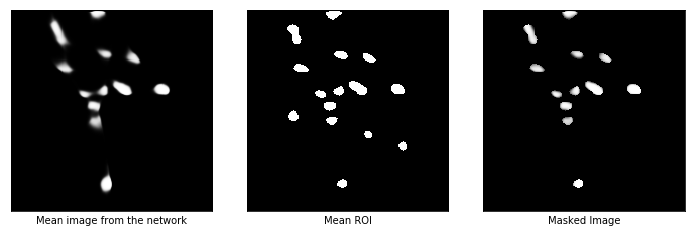

Loss: 0.010618312
Dice coefficient:  0.7006864243202509



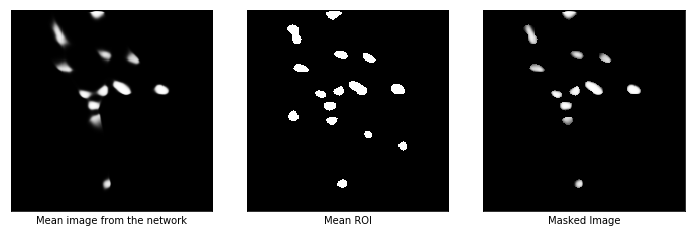

Loss: 0.010008126
Dice coefficient:  0.6902284480653791



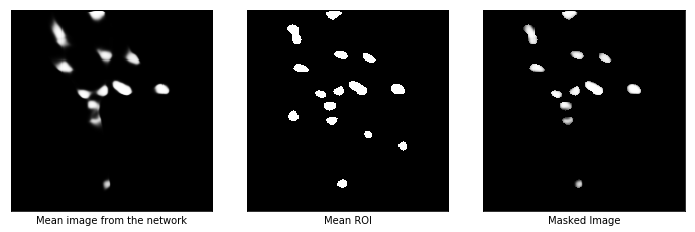

Loss: 0.0097187115
Dice coefficient:  0.7149110356899336



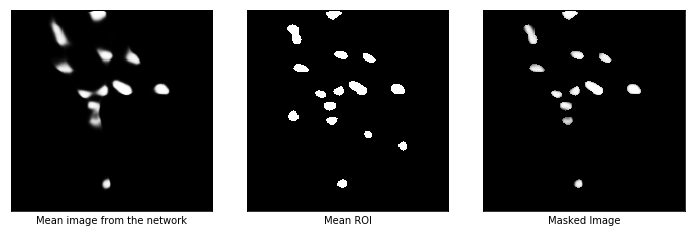

Loss: 0.00941584
Dice coefficient:  0.7239417039336974



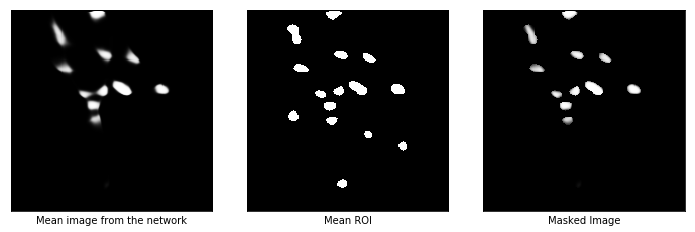

Loss: 0.010669265
Dice coefficient:  0.6898704160634442



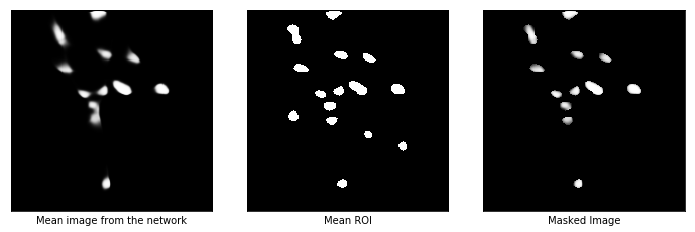

Loss: 0.009853345
Dice coefficient:  0.7048515308569914



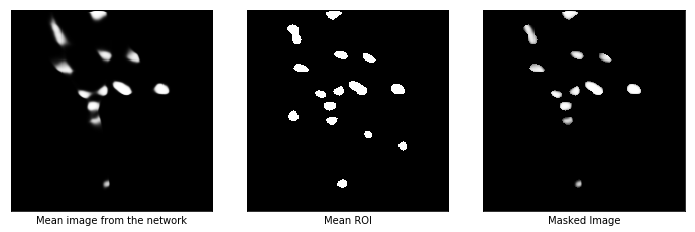

Loss: 0.009778059
Dice coefficient:  0.708103965496049



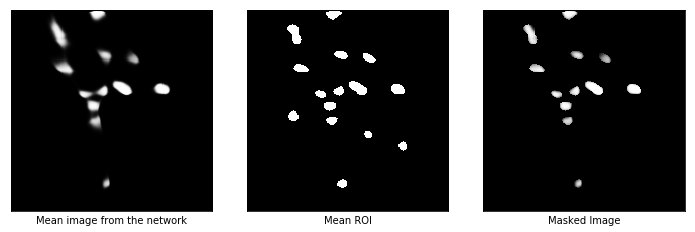

Loss: 0.01000421
Dice coefficient:  0.6981890483580914



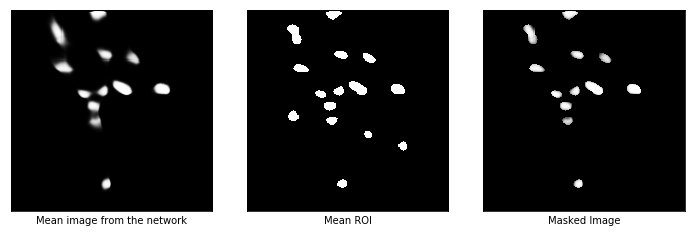

Loss: 0.009085539
Dice coefficient:  0.7265542480339805



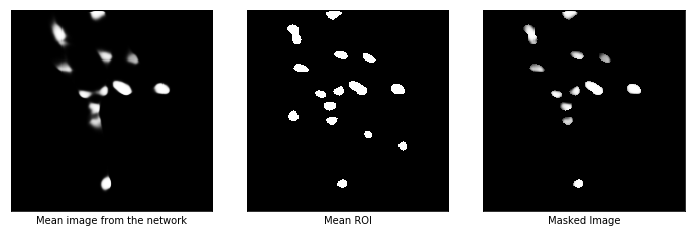

Loss: 0.010480889
Dice coefficient:  0.6999415140391136


In [13]:
#plot for mean image of last 10 steps w.r.t mean roi 
for i in range(10):
    mean_image = de_list[len(de_list) - 10 + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - 10 + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

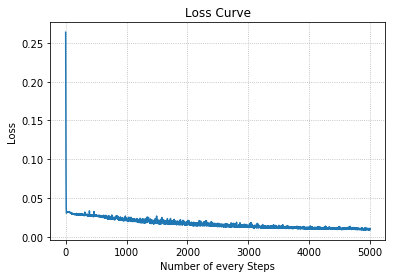

In [14]:
utils_vis.plot_loss(loss_list)

-------------------------------------------------

# Predict

Mean image as input!



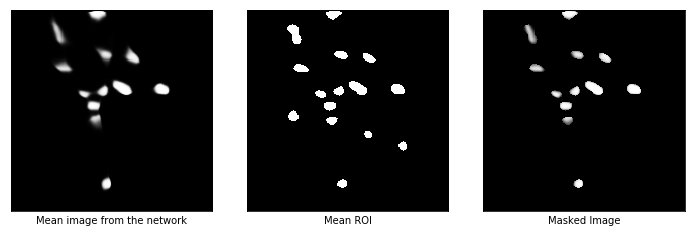

MSE for predicted image:  0.009730606079101563
Dice coefficient:  0.7078931274282626
Mean image as input!



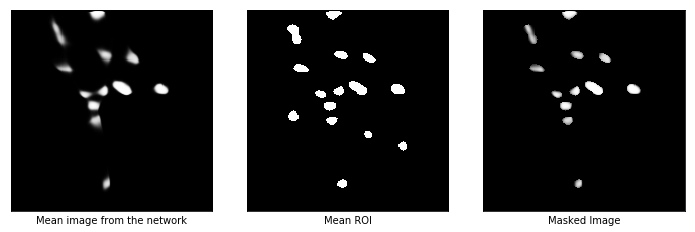

MSE for predicted image:  0.010162772369384766
Dice coefficient:  0.68629629058655
Mean image as input!



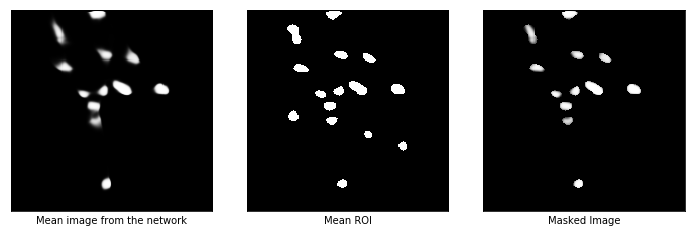

MSE for predicted image:  0.0092809814453125
Dice coefficient:  0.7250366592149866
Mean image as input!



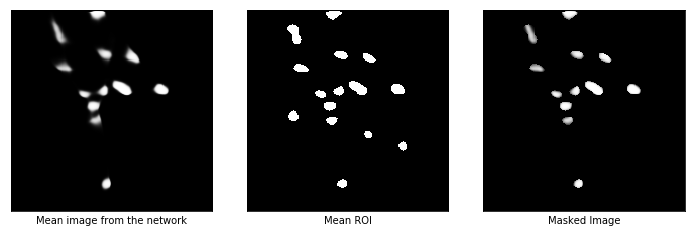

MSE for predicted image:  0.009701277160644532
Dice coefficient:  0.7081517962853527
Mean image as input!



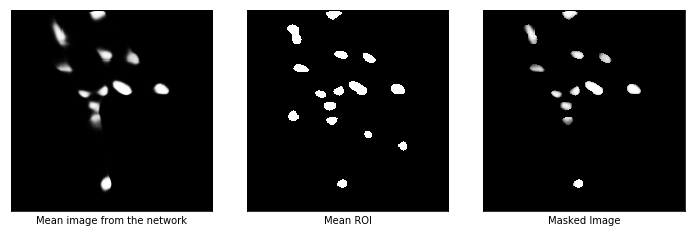

MSE for predicted image:  0.010149354553222656
Dice coefficient:  0.7029124706585598


In [15]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(x_test).shuffle(10000).repeat(REPEAT).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices
    
    if mean_in:
        print('Mean image as input!')
        mean_img = img_mean(test_batch, IMG_SIZE)
        mean_img = min_max_norm(mean_img)
        conv_img = model(mean_img)
        
        conv_image = np.asarray(conv_img) #cast tf object into np array
        masked_image = masked_img(conv_image, mean_roi)
        inp_imgs = [np.squeeze(conv_img), mean_roi, masked_image]
    else:
        print('Mean of output from the network!')
        conv_img = model(test_batch)
        mean_img = img_mean(conv_img, IMG_SIZE)
        mean_img = min_max_norm(mean_img)

        mean_image = np.asarray(mean_img) #cast tf object into np array
        masked_image = masked_img(mean_image, mean_roi)
        inp_imgs = [np.squeeze(mean_img), mean_roi, masked_image]

    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(conv_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, conv_image))
    
    sums+=1
    
    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [16]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

input_1
coord_conv
batch_normalization
activation
coord_conv_1
batch_normalization_1
activation_1
coord_conv_2
activation_2


In [17]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
layer_output = layer_dict[layer_name].output

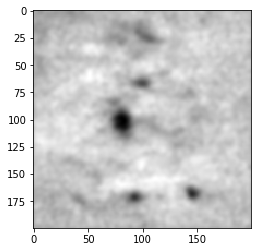

In [18]:
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(mean_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

Shape of feature maps: (1, 200, 200, 64)
Number of feature maps in layer:  64


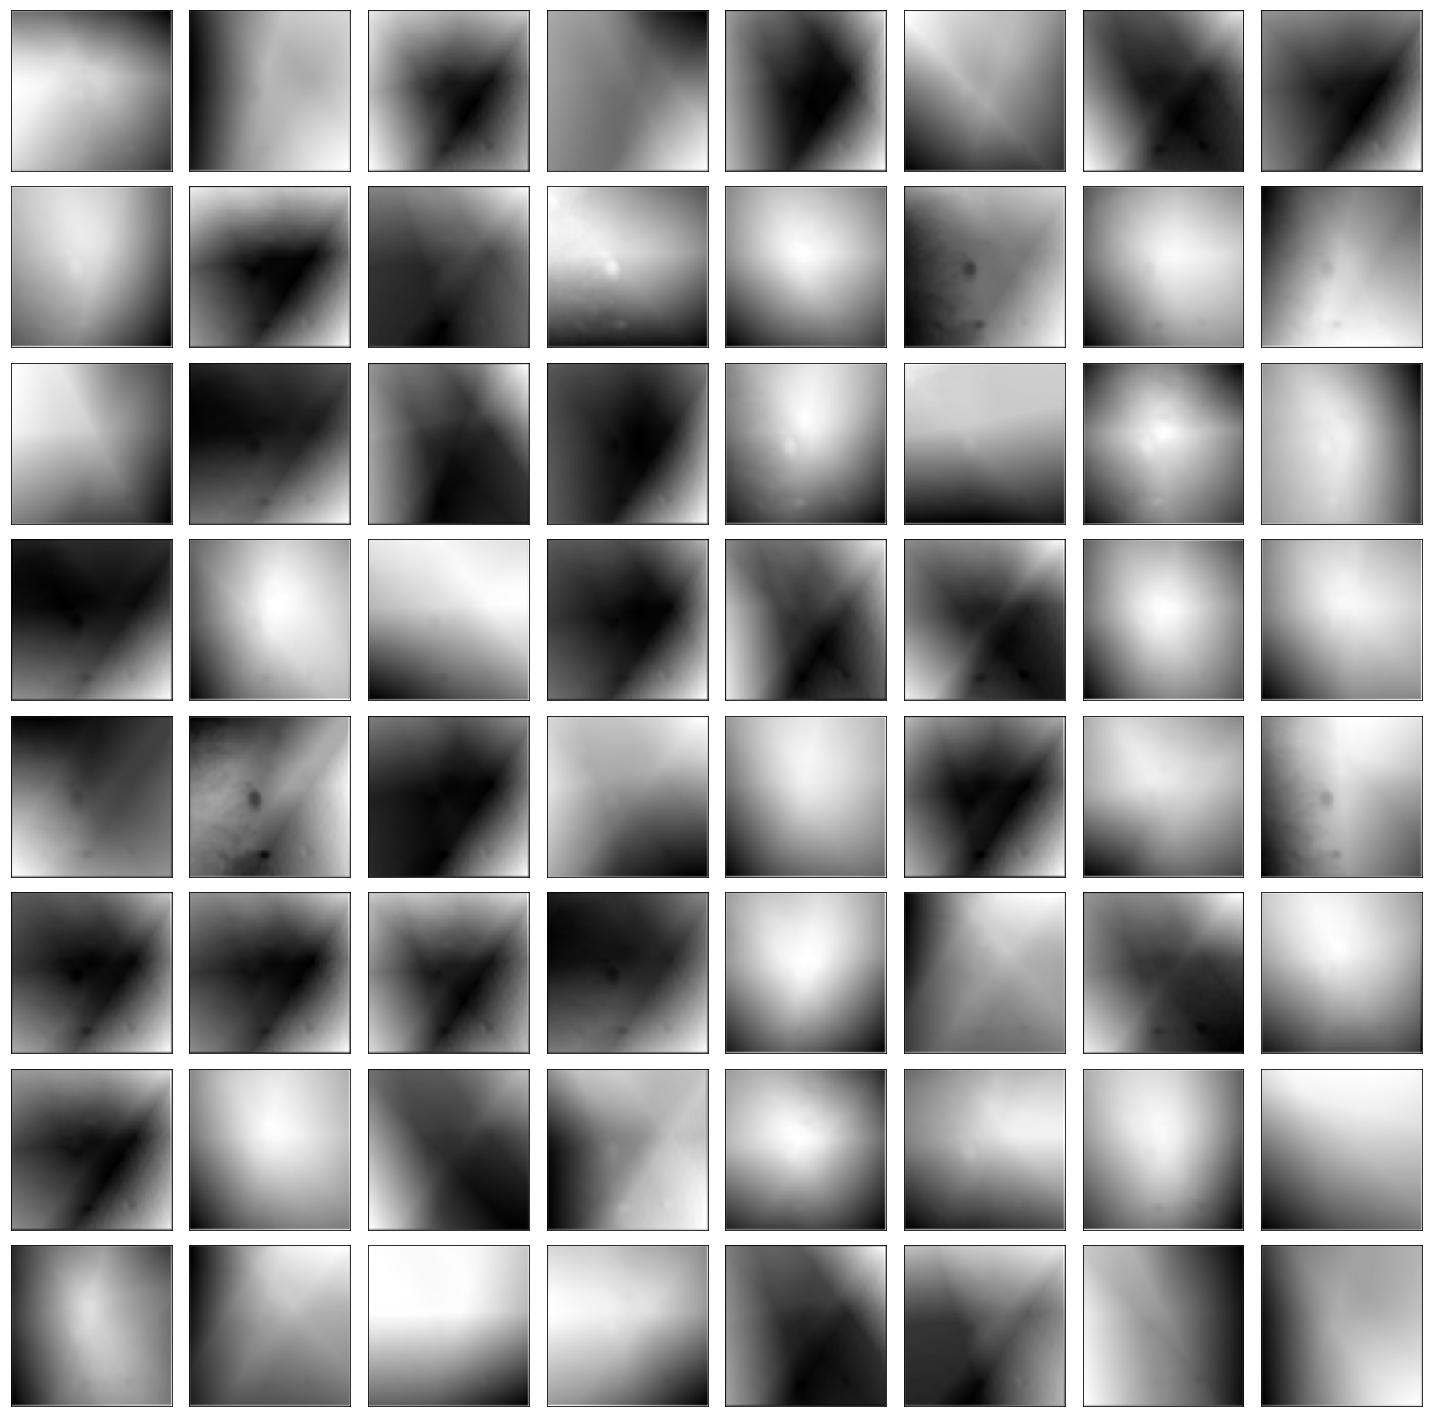

In [22]:
test_map = feature_maps(model, '{}_1'.format(layer_name), test_img)
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

Shape of feature maps: (1, 200, 200, 32)
Number of feature maps in layer:  32


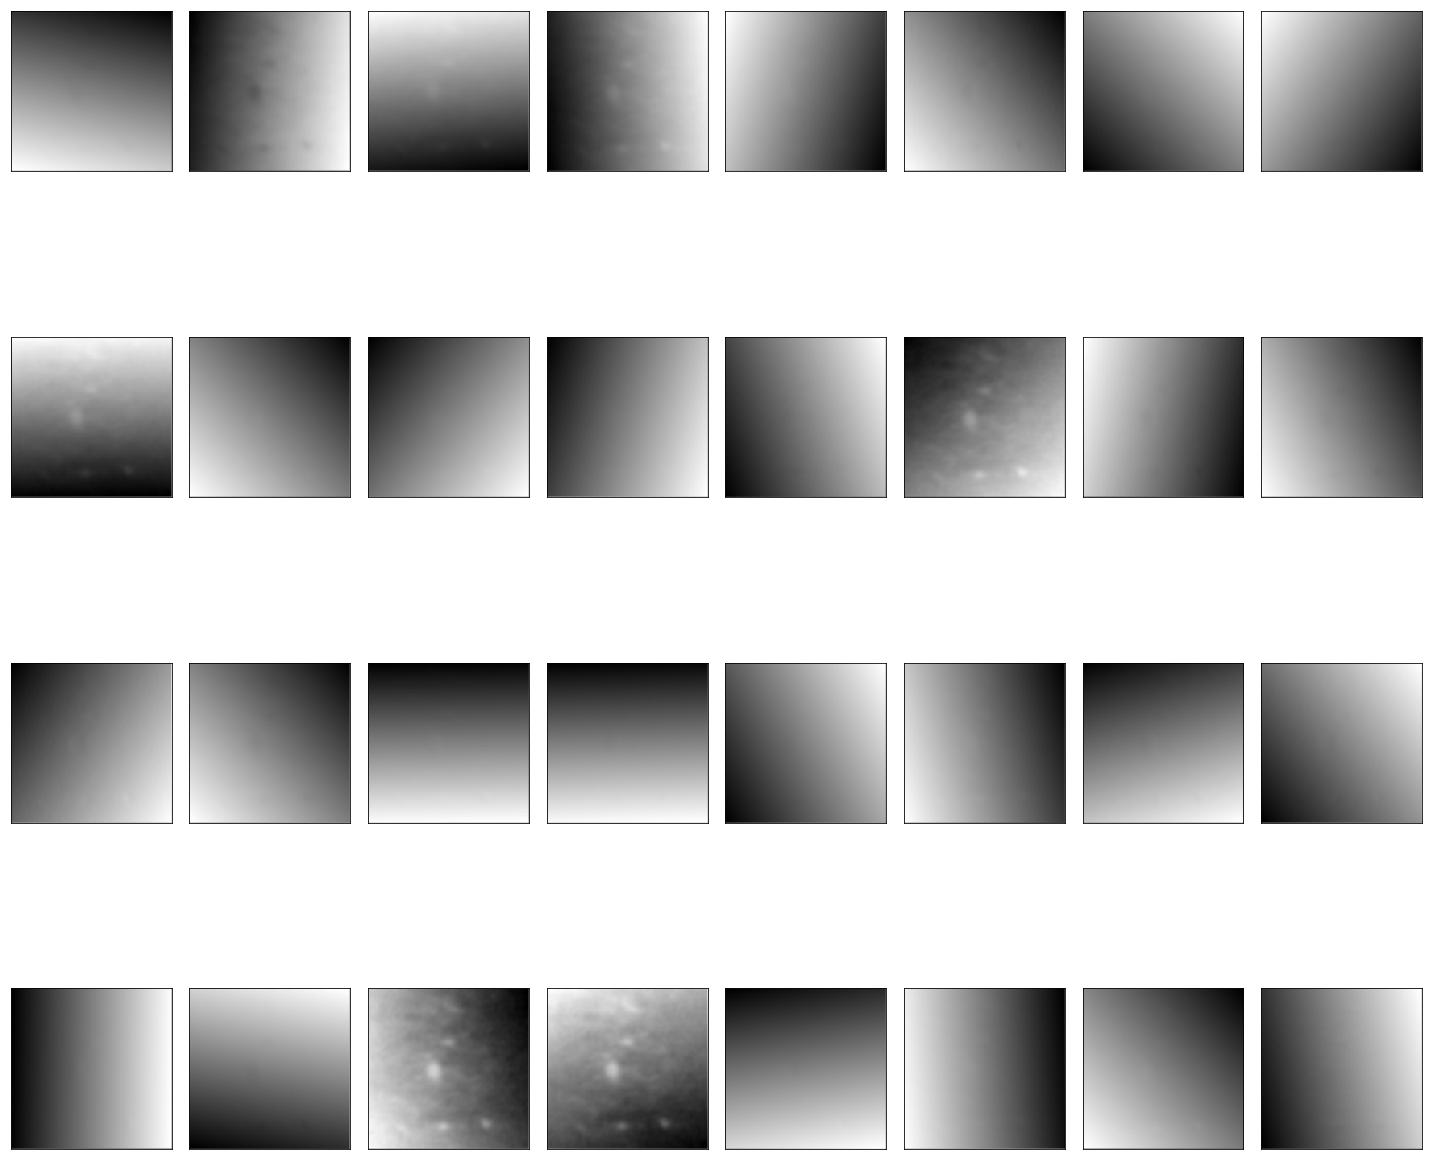

In [23]:
test_map02 = feature_maps(model, '{}'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 1)]     0         
_________________________________________________________________
coord_conv (CoordConv)       (None, 200, 200, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 200, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 200, 200, 32)      0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 200, 200, 64)      19648     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 200, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 200, 200, 64)      0     